In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [26]:
# Load the dataset
data = pd.read_csv('../Data/Raw/VRE_production_in_france_data_2020_2021.csv')

In [27]:
# Convert timestamp to datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [28]:
print(data.columns)

Index(['timestamp', 'Date and Hour', 'Date', 'StartHour', 'EndHour', 'Source',
       'Production', 'dayOfYear', 'dayName', 'monthName', 'GHI', 'DNI',
       'Wind_Speed_2m', 'Wind_Direction_2m', 'Temp_2m', 'RH_2m', 'Pressure',
       'wind_speed_50m', 'wind_direction_50m', 'temp_50m', 'density_VT',
       'pressure_VT', 'ri_number', 'rh_50m', 'rmol_VT'],
      dtype='object')


In [29]:
# Filter data for a specific source (e.g., 'Solar' or 'Wind')
source = 'Solar'  # Change to 'Wind' for wind energy
filtered_data = data[data['Source'] == source]

In [31]:
# Select relevant columns for modeling
features = ['GHI', 'DNI', 'Wind_Speed_2m', 'Temp_2m', 'RH_2m', 'Pressure', 'Pressure', 'wind_speed_50m', 'wind_direction_50m', 'temp_50m', 'density_VT', 'pressure_VT', 'ri_number', 'rh_50m', 'rmol_VT']
# features = ['Pressure', 'wind_speed_50m', 'wind_direction_50m', 'temp_50m', 'density_VT', 'pressure_VT', 'ri_number', 'rh_50m', 'rmol_VT']
target = 'Production'

In [32]:
# Ensure there are no missing values
filtered_data = filtered_data.dropna(subset=features + [target])

In [33]:
# LSTM Implementation
# Prepare data for LSTM (sequential data with sliding windows)
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 24  # Example: Use 24 hours of data for prediction
X_lstm = filtered_data[target].values
X_lstm, y_lstm = create_sequences(X_lstm, sequence_length)

In [34]:
# Split into training and testing sets
split_idx = int(0.8 * len(X_lstm))
X_train, X_test = X_lstm[:split_idx], X_lstm[split_idx:]
y_train, y_test = y_lstm[:split_idx], y_lstm[split_idx:]

In [35]:
# Reshape data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [36]:
# Build the LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

In [37]:
# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
179/179 [==============================] - 4s 14ms/step - loss: 2305547.7500
Epoch 2/10
179/179 [==============================] - 2s 14ms/step - loss: 2149994.0000
Epoch 3/10
179/179 [==============================] - 3s 14ms/step - loss: 1919476.2500
Epoch 4/10
179/179 [==============================] - 3s 14ms/step - loss: 1866882.1250
Epoch 5/10
179/179 [==============================] - 2s 13ms/step - loss: 1804314.1250
Epoch 6/10
179/179 [==============================] - 2s 13ms/step - loss: 1813515.1250
Epoch 7/10
179/179 [==============================] - 2s 13ms/step - loss: 1778256.2500
Epoch 8/10
179/179 [==============================] - 2s 14ms/step - loss: 1828147.0000
Epoch 9/10
179/179 [==============================] - 2s 14ms/step - loss: 1788404.3750
Epoch 10/10
179/179 [==============================] - 2s 13ms/step - loss: 1778382.1250


In [38]:
# Evaluate the LSTM model
y_pred = lstm_model.predict(X_test)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"LSTM Model RMSE: {rmse_lstm}")

45/45 [==============================] - 1s 7ms/step
LSTM Model RMSE: 1495.5329568521834


In [39]:
print(y_test)

[3484    2 3339 ...   44    3    2]


In [40]:
# Example: Replace these with your actual variable names
actual_values = y_test.flatten()  # Replace with your actual variable
predicted_values = y_pred.flatten()  # Replace with your predicted variable

# Create a DataFrame
results_df = pd.DataFrame({
    'Actual': actual_values,
    'Predicted': predicted_values
})

# Save to CSV
results_df.to_csv('../Data/Processed/Wind_lstm_results.csv', index=False)

5728 8640 1432


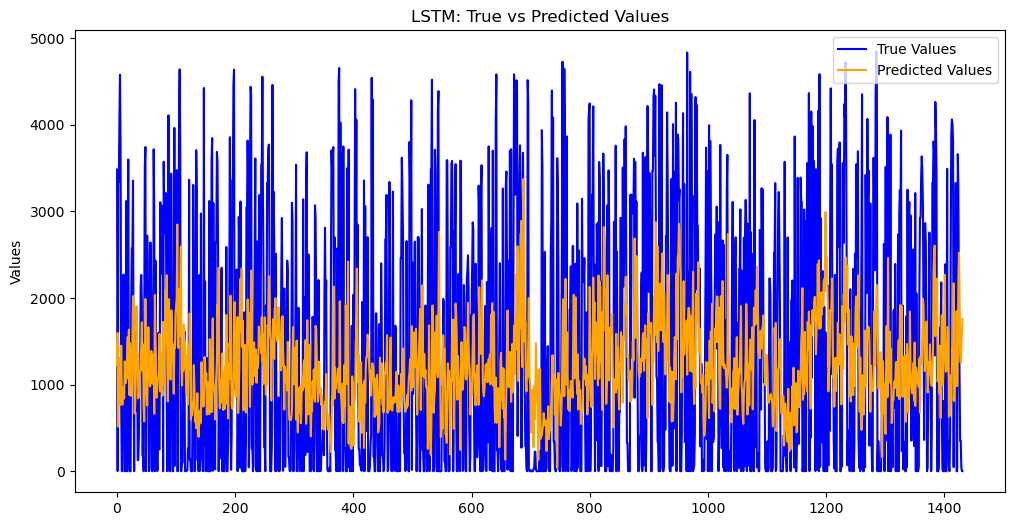

In [42]:
# Align test timestamps with y_test
train_timestamps = data['timestamp'][:split_idx]
test_timestamps = data['timestamp'][split_idx:]

print(len(train_timestamps), len(test_timestamps), len(y_test))
# Visualize with corrected alignment
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='True Values', color='blue')
plt.plot(range(len(y_test)), y_pred, label='Predicted Values', color='orange')
plt.title('LSTM: True vs Predicted Values')
plt.ylabel('Values')
plt.legend()
plt.show()

In [33]:
# Prophet Implementation
# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_data = filtered_data[['timestamp', 'Production']].rename(columns={'timestamp': 'ds', 'Production': 'y'})